# Library

In [11]:
# import the required libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
from shutil import copyfile
import random

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Tensorflow version 1.13.1


# Dataset

When I created dataset, I took photos of my face and our family's face. Thus, I can't put them on Github. Also, I collected photos from websites and I put them on folder.

In [12]:
print("The number of images with facemask labelled 'yes':",len(os.listdir('.../train/yesmask')))
print("The number of images with facemask labelled 'wrong':",len(os.listdir('.../train/wrongmask')))
print("The number of images with facemask labelled 'no':",len(os.listdir('.../train/nomask')))

The number of images with facemask labelled 'yes': 473
The number of images with facemask labelled 'wrong': 471
The number of images with facemask labelled 'no': 519


In [13]:
INIT_LR = 1e-4
EPOCHS = 50
BS = 32

In [15]:
# the list of data and class images
print("loading images...")
imagePaths = list(paths.list_images(".../train"))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]

    # load the input image (224x224) and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

#the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, random_state=42)

loading images...


# Image Augmentation

In [16]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

# Loading the Base Model

In [17]:
from tensorflow.keras.applications.vgg16 import VGG16

baseModel = VGG16(input_shape = (224, 224, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

# Compile and Fit - VGG16

In [18]:
# construct the head of the model that will be placed on top of the base model

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

# compile our model
print("compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

# train the head of the network
print("training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

# make predictions on the testing set
print(" evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))




compiling model...
training head...
Epoch 1/50
34/34 [==============================] - 389s 11s/step - loss: 0.7029 - acc: 0.6156 - val_loss: 0.6170 - val_acc: 0.6667
Epoch 2/50
34/34 [==============================] - 399s 12s/step - loss: 0.6440 - acc: 0.6504 - val_loss: 0.5865 - val_acc: 0.6704
Epoch 3/50
34/34 [==============================] - 468s 14s/step - loss: 0.6255 - acc: 0.6707 - val_loss: 0.5630 - val_acc: 0.7282
Epoch 4/50
34/34 [==============================] - 508s 15s/step - loss: 0.5914 - acc: 0.7051 - val_loss: 0.5433 - val_acc: 0.7503
Epoch 5/50
34/34 [==============================] - 529s 16s/step - loss: 0.5663 - acc: 0.7187 - val_loss: 0.5268 - val_acc: 0.7589
Epoch 6/50
34/34 [==============================] - 482s 14s/step - loss: 0.5503 - acc: 0.7313 - val_loss: 0.5111 - val_acc: 0.7601
Epoch 7/50
34/34 [==============================] - 427s 13s/step - loss: 0.5221 - acc: 0.7501 - val_loss: 0.4982 - val_acc: 0.7601
Epoch 8/50
34/34 [======================

In [34]:
# if you want to try another pre-trained model , uncomment last line
#load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

# Compile and Fit - MobileNet

In [36]:
# construct the head of the model that will be placed on top of the base model

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
#headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

# compile our model
print("compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

# train the head of the network
print("training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

# make predictions on the testing set
print(" evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))




compiling model...
training head...
Epoch 1/50
34/34 [==============================] - 45s 1s/step - loss: 0.6984 - acc: 0.6371 - val_loss: 0.5611 - val_acc: 0.7146
Epoch 2/50
34/34 [==============================] - 43s 1s/step - loss: 0.5390 - acc: 0.7310 - val_loss: 0.4851 - val_acc: 0.7638
Epoch 3/50
34/34 [==============================] - 44s 1s/step - loss: 0.4657 - acc: 0.7661 - val_loss: 0.4447 - val_acc: 0.7946
Epoch 4/50
34/34 [==============================] - 43s 1s/step - loss: 0.4231 - acc: 0.7833 - val_loss: 0.4107 - val_acc: 0.8253
Epoch 5/50
34/34 [==============================] - 44s 1s/step - loss: 0.3919 - acc: 0.8076 - val_loss: 0.3993 - val_acc: 0.8339
Epoch 6/50
34/34 [==============================] - 44s 1s/step - loss: 0.3868 - acc: 0.8138 - val_loss: 0.3761 - val_acc: 0.8376
Epoch 7/50
34/34 [==============================] - 45s 1s/step - loss: 0.3702 - acc: 0.8310 - val_loss: 0.3651 - val_acc: 0.8462
Epoch 8/50
34/34 [==============================] - 44

In [19]:
saved_model_path = "mymodel_vgg.h5"
model.save(saved_model_path) #save your model 

# VGG16

In [30]:
import matplotlib.pyplot as plt
def plot_acc_loss(results, epochs):
    acc = results.history['acc']
    loss = results.history['loss']
    val_acc = results.history['val_acc']
    val_loss = results.history['val_loss']
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(range(1,epochs), acc[1:], label='Train_acc')
    plt.plot(range(1,epochs), val_acc[1:], label='Test_acc')
    plt.title('Accuracy over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(range(1,epochs), loss[1:], label='Train_loss')
    plt.plot(range(1,epochs), val_loss[1:], label='Test_loss')
    plt.title('Loss over ' + str(epochs) +  ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.show()
 


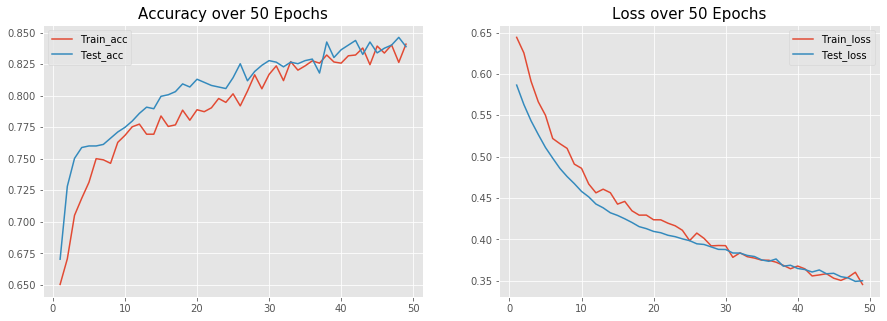

In [31]:
plot_acc_loss(H, EPOCHS)

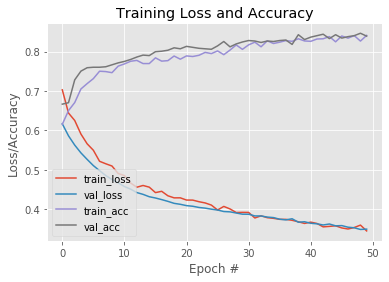

In [32]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig("plot")

# MobileNet

In [37]:
import matplotlib.pyplot as plt
def plot_acc_loss(results, epochs):
    acc = results.history['acc']
    loss = results.history['loss']
    val_acc = results.history['val_acc']
    val_loss = results.history['val_loss']
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(range(1,epochs), acc[1:], label='Train_acc')
    plt.plot(range(1,epochs), val_acc[1:], label='Test_acc')
    plt.title('Accuracy over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(range(1,epochs), loss[1:], label='Train_loss')
    plt.plot(range(1,epochs), val_loss[1:], label='Test_loss')
    plt.title('Loss over ' + str(epochs) +  ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.show()
 

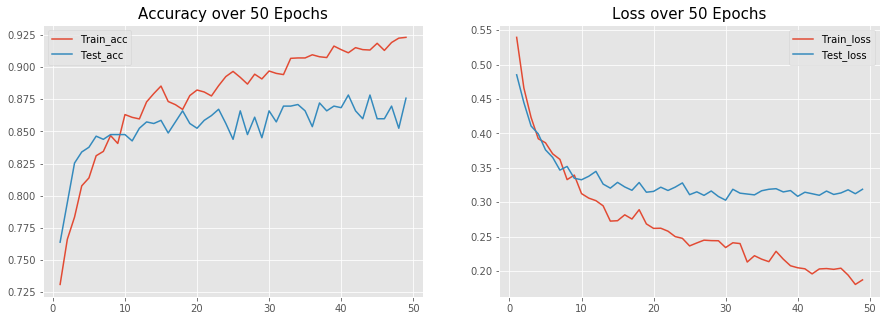

In [38]:
plot_acc_loss(H, EPOCHS)

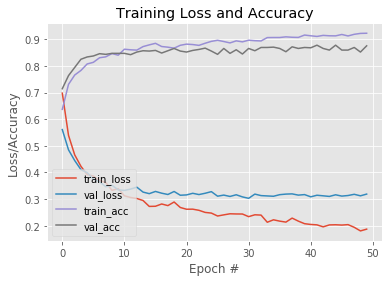

In [39]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig("plot")

In [41]:
saved_model_path = "mymodel_mobiletnet.h5"
model.save(saved_model_path) #save your model 

# DEMO OpenCV

In [ ]:
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg

model = tf.keras.models.load_model('mymodel_mobiletnet.h5')

labels_dict={0:'No Mask ! Please wear your mask!',1:'Wrong mask! It protects you from COVID-19',2:'Yes Mask! Perfect!'}
color_dict={0:(255,10,10),1:(0,0,255),2:(0,255,0)}

size = 4
webcam = cv2.VideoCapture(0) #Use camera 0

# We load the xml file
classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

while True:
    (rval, im) = webcam.read()
    im=cv2.flip(im,1,1) #Flip to act as a mirror

    # Resize the image to speed up detection
    mini = cv2.resize(im, (im.shape[1] // size, im.shape[0] // size))

    # detect MultiScale / faces 
    faces = classifier.detectMultiScale(mini)

    # Draw rectangles around each face
    for f in faces:
        (x, y, w, h) = [v * size for v in f] #Scale the shapesize backup
        #Save just the rectangle faces in SubRecFaces
        face_img = im[y:y+h, x:x+w]
        resized=cv2.resize(face_img,(224,224))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,224,224,3))
        reshaped = np.vstack([reshaped])
        result=model.predict(reshaped)
        
        label=np.argmax(result,axis=1)[0]
        (nomask,wrongmask,yesmask) = model.predict(reshaped)[0]
        #print(label)
      
    
        label2 = "{}: {:.2f}%".format(labels_dict[label], max(nomask,wrongmask,yesmask) * 100)

        # display the label and bounding box rectangle on the output
        # frame
        cv2.putText(im, label2, (x, y - 10),
        cv2.FONT_HERSHEY_SIMPLEX, 0.85, color_dict[label], 2)

        
    # Show the image
    cv2.imshow('LIVE',   im)
    key = cv2.waitKey(10)
    # if Esc key is press then break out of the loop 
    if key == 27: #The Esc key
        break
# Stop video
webcam.release()

# Close all started windows
cv2.destroyAllWindows()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
